In [4]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
#plt.style.use('ggplot')
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

import nltk
import collections

In [5]:
# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
from google.oauth2 import service_account

# Instantiates a client
client = language.LanguageServiceClient()

Text: Hello, world!
Sentiment: 0.30000001192092896, 0.30000001192092896


In [8]:
raw_data = pd.read_excel('English Data-the_car_connection news en 4774.xlsx')

In [23]:
raw_data['length'].describe()

count     4774.000000
mean      2665.715752
std       1305.162442
min        368.000000
25%       1800.000000
50%       2302.500000
75%       3096.000000
max      10000.000000
Name: length, dtype: float64

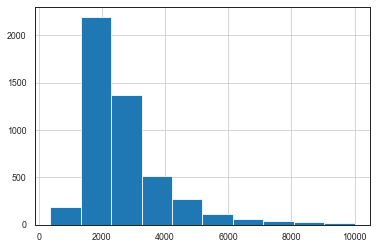

In [24]:
raw_data['length'].hist()

In [99]:
# import brand list
brand_list = pd.read_csv('brand_list.csv', header=None, names=['brand'])
s_brand_list = set(brand_list['brand'].values)

In [130]:
# find subset of brand list from article
article_brand = []
for i, j in enumerate(raw_data['text']):
    # tokenize text data to subset of brand list
    brand_appeared = set(nltk.word_tokenize(j)).intersection(s_brand_list)
    len_brand_appeared = len(brand_appeared)
    if not len_brand_appeared == 0:
        count_brands_appeared = []
        for k in brand_appeared:
            count_brands_appeared.append([k, j.count(k)])
        article_brand.append([i, count_brands_appeared, len_brand_appeared])

In [138]:
# transform list, article, brand, # of brand, to dataframe
df_brand_appeared = pd.DataFrame(article_brand, columns=['article#', 'brand', 'brand#'])

In [144]:
# extract articles that mention about only one brand
appeared_once = df_brand_appeared[df_brand_appeared['brand#']<2]

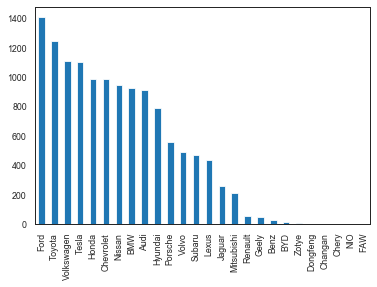

In [207]:
# analyze statistics of share of voice with entire dataset
for_share_of_voice = []
for i in article_brand:
    for j in i[1]:
        for_share_of_voice.extend([j[0]])

share_of_voice = pd.Series(for_share_of_voice)
share_of_voice.value_counts().plot(kind='bar')

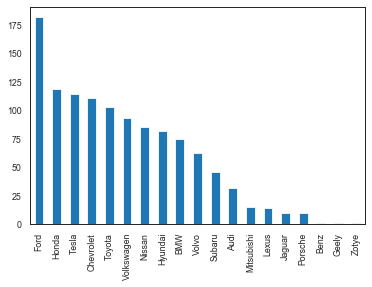

In [214]:
# analyze statistics of share of voice with articles that mention about only one brand
share_of_voice_appeared_once = []
for i in appeared_once['brand']:
    share_of_voice_appeared_once.extend([i[0][0]])

pd.Series(share_of_voice_appeared_once).value_counts().plot(kind='bar')

In [215]:
# extract honda and tesla from all dataset
index_honda_tesla = []
for row in appeared_once.itertuples(name=None):
    if ['Honda', 'Tesla'].count(row[2][0][0]):
        index_honda_tesla.extend([row[1]])

raw_data_honda_tesla = raw_data.loc[index_honda_tesla]

In [228]:
# function to access google nlp api for sentiment analysis
def sample_analyze_sentiment(text_content):
    """
    Analyzing Sentiment in a String

    Args:
      text_content The text content to analyze
    """

    # Available types: PLAIN_TEXT, HTML
    type_ = enums.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "en"
    document = {"content": text_content, "type": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = enums.EncodingType.UTF8

    response = client.analyze_sentiment(document, encoding_type=encoding_type)
    return response

In [240]:
# run sentiment analysis with google nlp api
response_google_api = []
for j, i in enumerate(raw_data_honda_tesla['text']):
    tmp = sample_analyze_sentiment(i)
    response_google_api.append([tmp])

In [302]:
# export results of sentiment analysis to csv
pd.DataFrame(response_google_api, index=raw_data_honda_tesla.index).to_csv('response_google_api_sentiment.csv')

In [251]:
# make dataframe with results of sentiment analysis
sentiment_score = []
for i in response_google_api:
    sentiment_score.append([i[0].document_sentiment.score, i[0].document_sentiment.magnitude])

df_sentiment_score = pd.DataFrame(sentiment_score, index=raw_data_honda_tesla.index, columns=['score', 'magnitude'])
df_data_honda_tesla_w_sentiment_score = pd.concat([raw_data_honda_tesla, df_sentiment_score], axis=1)

In [264]:
# list of honda's article index
index_honda = []
for row in appeared_once.itertuples(name=None):
    if ['Honda'].count(row[2][0][0]):
        index_honda.extend([row[1]])

# list of tesla's article index
index_tesla = []
for row in appeared_once.itertuples(name=None):
    if ['Tesla'].count(row[2][0][0]):
        index_tesla.extend([row[1]])

In [271]:
# Honda's sentiment score statistics 
df_data_honda = df_data_honda_tesla_w_sentiment_score.loc[index_honda]
df_data_honda['score'].describe()

count    119.000000
mean       0.041176
std        0.157530
min       -0.300000
25%       -0.100000
50%        0.000000
75%        0.100000
max        0.500000
Name: score, dtype: float64

In [272]:
# Tesla's sentiment score statistics 
df_data_tesla = df_data_honda_tesla_w_sentiment_score.loc[index_tesla]
df_data_tesla['score'].describe()

count    114.000000
mean      -0.001754
std        0.104739
min       -0.300000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.200000
Name: score, dtype: float64

In [298]:
# sorting honda's articles with large magnitude
df_data_honda.sort_values(by='magnitude', ascending=False).head().rename(columns={'Unnamed: 0':'no'})

,no,text,title,time,length,score,magnitude
410,457,"Hidden in crumpled metal, rippled hoods, shatt...",NaN,"August 26, 2019",8916,-0.2,29.400000
3404,3626,We're now entering the second half of the year...,2016 Honda Pilot long-term road test: from car...,"September 8, 2016",6429,0.1,17.799999
2602,2713,"Minivans have two critical missions. Sure, the...",2018 Honda Odyssey first drive video,"May 15, 2017",3940,0.3,17.400000
2400,2504,We've now started the second half of our yearl...,2017 Chrysler Pacifica Limited long-term road ...,"July 28, 2017",6863,0.1,17.100000
3118,3267,In the last 11 months we've talked a lot about...,2016 Honda Pilot long-term road test: which ac...,"December 5, 2016",5521,0.0,16.000000


In [299]:
# sorting tesla's articles with large magnitude
df_data_tesla.sort_values(by='magnitude', ascending=False).head().rename(columns={'Unnamed: 0':'no'})

,no,text,title,time,length,score,magnitude
4060,4293,"Last August, we told you about Chinese entrepr...",Faraday Future's 1000-HP Electric Car: Should ...,"January 5, 2016",4361,0.2,16.200001
3013,3130,The past few months haven't been kind to Farad...,Faraday unveils FF 91 electric car: can it sal...,"January 4, 2017",6451,0.0,16.000000
2698,2809,"Yesterday, Tesla slipped past General Motors t...",GM swings back at Tesla with Super Cruise self...,"April 11, 2017",4889,0.2,15.400000
4606,4844,When Steve Jobs tapped Tim Cook to be his succ...,The Tesla Powerwall: Does It Really Mean The E...,"May 8, 2015",4104,0.1,13.200000
3271,3465,Tesla CEO Elon Musk waded into Donald Trump te...,"Elon Musk has a Donald Trump moment, says crit...","October 20, 2016",4916,0.0,13.200000


In [310]:
# function to access google nlp api for entities sentiment analysis
def sample_analyze_entity_sentiment(text_content):
    """
    Analyzing Entity Sentiment in a String

    Args:
      text_content The text content to analyze
    """
    # Available types: PLAIN_TEXT, HTML
    type_ = enums.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "en"
    document = {"content": text_content, "type": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = enums.EncodingType.UTF8

    response = client.analyze_entity_sentiment(document, encoding_type=encoding_type)
    return response

In [324]:
# run entities sentiment analysis with google nlp api
analyze_entity_sentiment = []
for i in raw_data_honda_tesla['text']:
    analyze_entity_sentiment.append([sample_analyze_entity_sentiment(i)])

In [325]:
# export results of entities sentiment analysis to csv
pd.DataFrame(analyze_entity_sentiment, index=raw_data_honda_tesla.index).to_csv('response_google_api_analyze_entity_sentiment.csv')

In [326]:
# transform list of results of entities sentiment analysis to dataframe
df_analyze_entity_sentiment = pd.DataFrame(analyze_entity_sentiment, index=raw_data_honda_tesla.index)
# honda's results of entities sentiment analysis with dataframe
df_honda_AES = df_analyze_entity_sentiment.loc[index_honda]
# tesla's results of entities sentiment analysis with dataframe
df_tesla_AES = df_analyze_entity_sentiment.loc[index_tesla]

In [381]:
# transform raw data of honda's results of entities sentiment analysis to organized data
honda_entities = []
for i in df_honda_AES.itertuples(name=None):
    entity = i[1].entities[0]
    honda_entities.append([entity.name, entity.sentiment.score, entity.sentiment.magnitude])

df_honda_entities = pd.DataFrame(honda_entities, index=df_honda_AES.index, columns=['name', 'score', 'magnitude'])

In [382]:
# transform raw data of tesla's results of entities sentiment analysis to organized data
tesla_entities = []
for i in df_tesla_AES.itertuples(name=None):
    entity = i[1].entities[0]
    tesla_entities.append([entity.name, entity.sentiment.score, entity.sentiment.magnitude])

df_tesla_entities = pd.DataFrame(tesla_entities, index=df_tesla_AES.index, columns=['name', 'score', 'magnitude'])

In [383]:
df_honda_entities.sort_values('magnitude', ascending=False).head(5)

,name,score,magnitude
2602,Honda Odyssey,0.2,10.1
2127,Chrysler Pacifica,0.3,10.0
4209,Takata,-0.3,8.6
2134,Honda Accord,0.2,7.7
3172,Civic Hatchback,0.0,7.6


In [384]:
df_tesla_entities.sort_values('magnitude', ascending=False).head(5)

,name,score,magnitude
3361,Tesla Motors,0.0,8.6
2628,Tesla,0.0,8.4
2461,IIHS,-0.1,8.1
2661,Tesla Autopilot,-0.2,8.0
3013,FF 91,0.0,7.1


In [385]:
df_honda_entities.sort_values('score', ascending=False).head(5)

,name,score,magnitude
880,structure,0.7,1.5
3187,Honda Accord,0.4,4.1
1382,suite,0.4,0.8
4364,HR-V,0.3,4.9
2127,Chrysler Pacifica,0.3,10.0


In [386]:
df_honda_entities.sort_values('score', ascending=True).head(5)

,name,score,magnitude
3432,drivers,-0.7,3.7
957,fuel pump,-0.5,2.0
4572,airbag recall,-0.5,1.0
4365,men,-0.5,1.0
1507,IIHS,-0.4,1.4


In [387]:
df_tesla_entities.sort_values('score', ascending=False).head(5)

,name,score,magnitude
3815,news,0.7,1.5
531,score,0.6,0.6
4651,news,0.6,1.9
4652,picks,0.5,1.5
154,Electric Car,0.3,3.5


In [388]:
df_tesla_entities.sort_values('score', ascending=True).head(5)

,name,score,magnitude
4657,impression,-0.6,1.3
2596,Joshua Brown,-0.3,1.5
2289,Tesla,-0.2,4.5
3166,AECOM,-0.2,2.3
3271,Elon Musk,-0.2,6.0
